In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *
from sklearn import metrics

In [3]:
PATH = "data/painter-by-numbers/"

In [4]:
!ls {PATH}

all_data_info.csv	   kernel		 test
all_train_data_info1.csv   models		 tmp
all_train_data_info_2.csv  sampleSubmission.csv  train
all_train_data_info.csv    submission_info.csv	 train_info.csv


In [42]:
all_data_csv = f'{PATH}all_data_info.csv'
all_data = pd.read_csv(all_data_csv)
all_data_q = all_data.query('in_train==True')
all_data_f = all_data_q.filter(items=['new_filename', 'artist'])
all_data_f.replace(to_replace=' ', value='_', inplace=True, regex=True)
all_data_f.to_csv(f'{PATH}all_train_data_info_indexed.csv')


In [6]:
label_csv = f'{PATH}all_train_data_info.csv'
n = len(list(open(label_csv)))-1
validation_idxs = get_cv_idxs(n)

In [21]:
label_df = pd.read_csv(label_csv)
label_df.head()

,new_filename,artist
0,102257.jpg,Barnett_Newman
1,75232.jpg,Barnett_Newman
2,29855.jpg,Tosa_Mitsuoki
3,62252.jpg,Barnett_Newman
4,63861.jpg,Barnett_Newman


In [22]:
label_df.pivot_table(index='artist', aggfunc=len).sort_values('new_filename', ascending=False)

,new_filename
artist,
Paul_Cezanne,412
Giovanni_Battista_Piranesi,402
Martiros_Saryan,399
Ilya_Repin,397
Camille_Pissarro,393
Vincent_van_Gogh,392
Theophile_Steinlen,389
Pierre-Auguste_Renoir,388
Boris_Kustodiev,388


In [7]:
image_sz=480
net_arch=resnet34
batch_sz=32

In [8]:
img_transforms = tfms_from_model(net_arch, image_sz, max_zoom=1.1)

In [9]:
def get_data(image_sz):
    tfms = tfms_from_model(net_arch, image_sz, max_zoom=1.3)
    return ImageClassifierData.from_csv(PATH, 'train', label_csv, bs=batch_sz, tfms=tfms, val_idxs=validation_idxs, test_name='test')

In [10]:
data = get_data(480)
data.classes

["'The_Tent'",
 '(Café_on_the_Boulevard_Clichy)_',
 '(Fruit_in_Basket)_',
 '(On_the_Seine)_',
 '(The_Tryst)',
 '(Three_Pears_and_Grapes)_',
 '1',
 '10.3.07',
 '10.7.06',
 '14',
 '15',
 '160_X_148',
 '1706),_Lieutenant_Admiral_of_Zeeland_',
 '18',
 '18.06.98',
 '1_(NOR)',
 '2',
 '2._Stanley_Hawk',
 '21_(NOR)',
 '23',
 '27_(Stone)',
 '2_(NOR)',
 '39',
 '4',
 '5.11.07',
 '500_Rakan_temples',
 '55_East_Division_Street',
 '69',
 '7',
 '71',
 '75',
 '76',
 '77',
 '7th_Avenue_Style',
 '8_Janvier_soir',
 'A.Y._Jackson',
 'A_(心)',
 'A_Back_Yard_Reminiscence_of_Brooklyn',
 'A_Fire',
 'A_Memory',
 'A_Shinnecock_Vale',
 'A_revolta_das_bonecas',
 'Abanindranath_Tagore',
 'Abdullah_Suriosubroto',
 'Abidin_Dino',
 'Abraham_Manievich',
 'Abraham_van_Strij',
 'Abstracted_',
 'Ad_Reinhardt',
 'Adam_Baltatu',
 'Adja_Yunkers',
 'Adolf_Dietrich',
 'Adolf_Fleischmann',
 'Adolf_Hitler',
 'Adolphe_Joseph_Thomas_Monticelli',
 'Adoration_of_the_Shepherds_',
 'Adriaen_Brouwer',
 'Adriaen_van_Ostade',
 'Adrien_Da

In [27]:
fn = PATH + data.trn_ds.fnames[0];fn

'data/painter-by-numbers/train/102257.jpg'

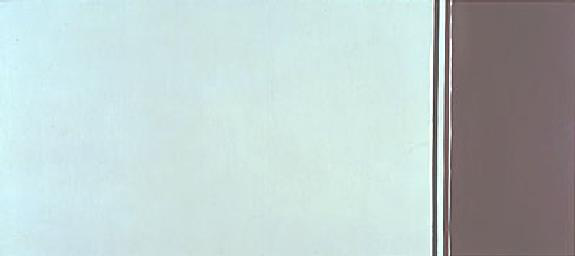

In [28]:
img = PIL.Image.open(fn); img

In [29]:
img.size

(575, 256)

In [50]:
size_d = {k: PIL.Image.open(PATH+k).size for k in data.trn_ds.fnames}
row_sz, col_sz = list(zip(*size_d.values()))
row_sz = np.array(row_sz)
col_sz = np.array(col_sz)
plt.hist(row_sz)

FileNotFoundError: [Errno 2] No such file or directory: 'data/painter-by-numbers/train/0.jpg'

(array([    0.,     0.,     0.,     0.,     0., 22424.,     0.,     0.,     0.,     0.]),
 array([479.5, 479.6, 479.7, 479.8, 479.9, 480. , 480.1, 480.2, 480.3, 480.4, 480.5]),
 <a list of 10 Patch objects>)

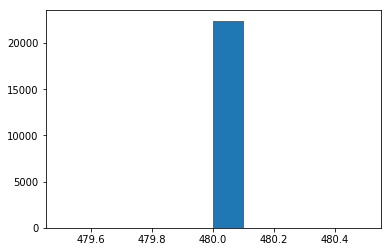

In [16]:
plt.hist(col_sz)

##  Learning

In [30]:
data = get_data(256)

In [11]:
net = ConvLearner.pretrained(net_arch, data)

 82%|████████▏ | 1626/1986 [03:15<00:43,  8.30it/s, loss=25.4]

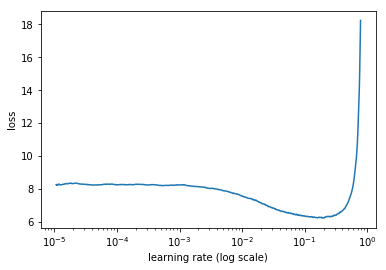

In [32]:
lrf=net.lr_find()
net.sched.plot()

In [34]:
lr = 0.1

In [35]:
net.fit(lr, 3, cycle_len=1, cycle_mult=2)

  4%|▍         | 77/1986 [00:09<03:51,  8.25it/s, loss=8.31]
epoch      trn_loss   val_loss   accuracy                     
    0      5.035804   4.576371   0.214151  
    1      4.720292   4.1714     0.245373                     
    3      4.557576   4.08034    0.246255                     
    4      4.254642   3.788467   0.286793                     
    5      3.842351   3.599948   0.32173                      
 46%|████▋     | 922/1986 [01:51<02:08,  8.27it/s, loss=3.54]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      3.583126   3.549943   0.331865                     



[array([3.54994]), 0.3318645348217811]

In [36]:
net.save(f'freezed_artists')

In [37]:
lrs = np.array([lr/9,lr/3,lr])

In [38]:
net.unfreeze()
net.fit(lrs, 3, cycle_len=1, cycle_mult=2)

 75%|███████▌  | 1498/1986 [07:04<02:18,  3.53it/s, loss=4.25]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 95%|█████████▍| 1877/1986 [08:53<00:30,  3.52it/s, loss=3.39]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    4      3.592606   3.285219   0.354715                     
 24%|██▎       | 471/1986 [02:14<07:11,  3.51it/s, loss=3.32]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    6      2.626587   2.812991   0.438562                     



[array([2.81299]), 0.4385622560801591]

In [39]:
net.save(f'256_artists')

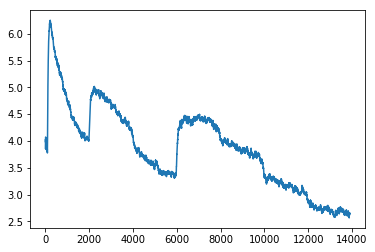

In [40]:
net.sched.plot_loss()

In [41]:
net.set_data(get_data(480))
net.freeze()
net.fit(lr, 3, cycle_len=1, cycle_mult=2)

 75%|███████▌  | 1498/1986 [10:11<03:19,  2.45it/s, loss=3.17]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    2      2.786211   2.748451   0.451026                     
  5%|▌         | 102/1986 [00:48<14:50,  2.12it/s, loss=3.12]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    3      3.426015   2.964513   0.413194                     
 38%|███▊      | 754/1986 [05:21<08:44,  2.35it/s, loss=3.15]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    4      3.068903   2.817001   0.435793                     
    5      2.734926   2.687275   0.461538                     
    6      2.626195   2.65731    0.468966                     



[array([2.65731]), 0.46896638550416775]

In [42]:
net.save(f'480_freezed_artists')

In [43]:
# restart point
#net.set_data(get_data(480))
#net.load(f'480_freezed_artists')

 78%|███████▊  | 1554/1986 [10:34<02:56,  2.45it/s, loss=9.85]

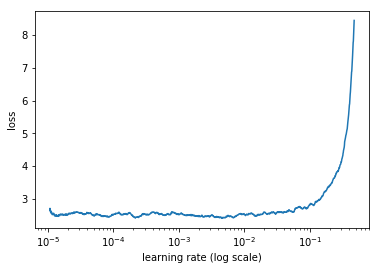

In [44]:
lrf=net.lr_find()
net.sched.plot()

In [45]:
lr = 0.001
lrs = np.array([lr/9,lr/3,lr])

In [ ]:
net.unfreeze()
net.fit(lrs, 3, cycle_len=1, cycle_mult=2)
net.save(f'480_unfreezed_artists')

  0%|          | 4/1986 [00:07<1:00:28,  1.83s/it, loss=2.97]
epoch      trn_loss   val_loss   accuracy                     
    0      2.577405   2.684805   0.462734  
    1      2.597275   2.644221   0.470603                     
 14%|█▍        | 287/1986 [04:50<28:36,  1.01s/it, loss=2.53]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



    3      2.476484   2.622058   0.474569                     
 38%|███▊      | 755/1986 [12:35<20:31,  1.00s/it, loss=2.44]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 13%|█▎        | 250/1986 [04:15<29:35,  1.02s/it, loss=2.46]

## Validation checks

In [ ]:
val_log_preds, y = net.TTA()
val_probs = np.exp(val_log_preds)
val_predicts = np.mean(val_probs, 0)

In [ ]:
val_predicts[0]

In [ ]:
y[1]

## Making kaggle solution

In [ ]:
test_log_preds, y = net.TTA(is_test=True)

In [ ]:
test_probs = np.exp(test_log_preds)

Get mean among TTA

In [ ]:
test_predicts = np.mean(test_probs, 0)

In [ ]:
data.test_ds.fnames[0]

In [ ]:
test_predicts[0]

## Manual test checks

In [ ]:
#check some values
check_i = 156
fn = PATH + data.test_ds.fnames[check_i];
print(test_predicts[check_i])
img = PIL.Image.open(fn); img

In [ ]:
ds = pd.DataFrame(test_predicts)
ds.columns = data.classes
ds.insert(0, 'img', [o[5:] for o in data.test_ds.fnames])
ds.head()
SUBM = f'{PATH}subm/'
os.makedirs(SUBM, exist_ok=True)
ds.to_csv(f'{SUBM}subm18072018', index=False)
FileLink(f'{SUBM}subm')

## Kernel

In [ ]:
net.load(f'480_unfreezed_artists')

train/73456.jpg
3.0290065e-07
Eyvind_Earle
['Ohara_Koson', 'Utagawa_Toyokuni_II', 'Unichi_Hiratsuka', 'Katsushika_Hokusai', 'Eyvind_Earle']


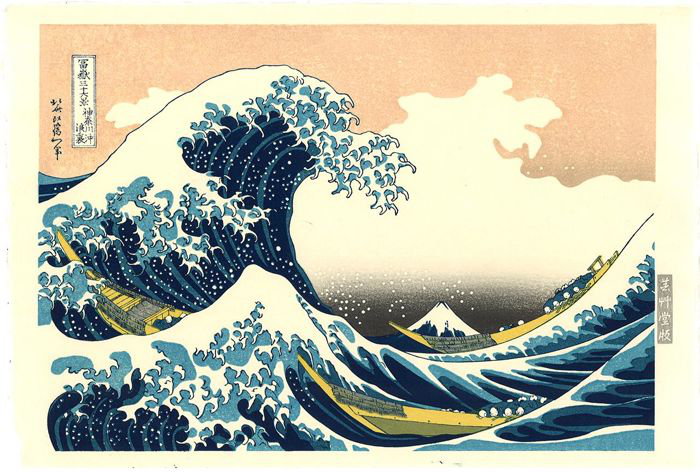

In [75]:
check_i = 313
img_size=480
#image_path = PATH + data.trn_ds.fnames[check_i];
print(data.trn_ds.fnames[check_i])
image_path = f'{PATH}kernel/wave'
predicts = identify_by_image(image_path, net_arch, img_size)
print(max_class(data.classes, predicts))
print(top_classes(data.classes, 5, predicts))

img = PIL.Image.open(image_path); img

In [68]:
def identify_by_image(file_path, net_arch, img_sz):
        trn_tfms, val_tfrms = tfms_from_model(net_arch, img_sz)
        img = trn_tfms(open_image(file_path))
        preds = net.predict_array(img[None])
        return np.exp(preds)

def classes_by_threshold(classes, threshold, predicts):
    thres_classes = []
    i = 0
    for predict in predicts[0]:
        if predict > threshold:
            thres_classes.append(classes[i])
        i = i + 1
    return thres_classes

def max_class(classes, predicts):
    return classes[np.argmax(predicts)]

def top_classes(classes, top, predicts):
    top_classes = []
    sorted_preds = predicts.argsort()[::1][0][-top:]
    for sorted_pred in sorted_preds:
        top_classes.append(classes[int(sorted_pred)])    
    return top_classes

In [ ]:
check_i = 12331
image_path = PATH + data.test_ds.fnames[check_i];
predicts = identify_by_image(image_path, net_arch, 400)
print(predicts)
print(classes_by_threshold(classes, 0.001, predicts))
print(test_predicts[check_i])
img = PIL.Image.open(image_path); img